### Coursework coding instructions (please also see full coursework spec)

Please choose if you want to do either Task 1 or Task 2. You should write your report about one task only.

For the task you choose you will need to do two approaches:
  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models
We should be able to run both approaches from the same colab file

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = '/content/drive/MyDrive/'
except Exception:
    data_dir = './data/'

In [3]:
# You will need to download any word embeddings required for your code, e.g.:

# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

# For any packages that Colab does not provide auotmatically you will also need to install these below, e.g.:

#! pip install torch

In [4]:
!pip install ekphrasis gensim spacy nltk
!python -m spacy download 'en_core_web_sm'
!python -m spacy download 'en_core_web_lg'

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


# Loading Data

In [425]:
%%bash
export GENSIM_DATA_DIR='./data/'
# python -m gensim.downloader --download glove-twitter-25
# python -m gensim.downloader --download word2vec-google-news-300
# python -m gensim.downloader --download fasttext-wiki-news-subwords-300
# python -m gensim.downloader --download glove-twitter-100
# python -m gensim.downloader --download glove-wiki-gigaword-300

[==================================================] 100.0% 376.1/376.1MB downloaded
2021-03-02 16:28:29,150 : __main__ : INFO : glove-wiki-gigaword-300 downloaded
2021-03-02 16:28:32,776 : __main__ : INFO : Data has been installed and data path is ./data/glove-wiki-gigaword-300/glove-wiki-gigaword-300.gz


In [134]:
%matplotlib inline

import os
import re
import codecs

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import gensim
import gensim.downloader as api
import matplotlib.pyplot as plt
import spacy
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from torch.utils.data import Dataset, random_split
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
# from ekphrasis.dicts.noslang.slangdict

In [7]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

In [8]:
# Load data
train_df = pd.read_csv(f'{data_dir}/train.csv')
test_df = pd.read_csv(f'{data_dir}/dev.csv')

In [9]:
train_df2 = pd.read_csv(f'{data_dir}/train_funlines.csv')

In [10]:
train_df = pd.concat([train_df, train_df2])
train_df.reset_index(inplace=True, drop=True)

In [11]:
train_df[-10:]

id                                           original        edit  \
17890  108238  How to block Facebook and Google from identify...    mistress   
17891  108239  How to block Facebook and Google from <identif...  mustaching   
17892  108240  Downtown Tokyo 's homeless fear <removal/> ahe...    Godzilla   
17893  108241  Israel signs pact to bar gay couples from adop...   Oligarchs   
17894  108242  Fear grips Chinese city as <virus/> lockdown b...     vampire   
17895  108243  Banning Facial <Recognition/> Is n’t Enough - ...   Cleansers   
17896  108244  Trump is reportedly threatening <Republicans/>...    children   
17897  108245  Peruvian indigenous group wins suit to block o...       Women   
17898  108246  Joe Rogan says he 's probably voting for <Bern...  Illuminati   
17899  108247  While Microsoft Was Making Its Climate Pledge ...       Spill   

       grades  meanGrade  
17890   33221        2.2  
17891   32221        2.0  
17892   32221        2.0  
17893   22100        1.0  
17894   22222        2.0  
17895   22222        2.0  
17896   21100        0.8  
17897   22110        1.2  
17898   22000        0.8  
17899   21111        1.2

In [12]:
train_df.head()

id                                           original     edit  grades  \
0  14530  France is ‘ hunting down its citizens who join...    twins   10000   
1  13034  Pentagon claims 2,000 % increase in Russian tr...  bowling   33110   
2   8731  Iceland PM Calls Snap Vote as Pedophile Furor ...    party   22100   
3     76  In an apparent first , Iran and Israel <engage...     slap   20000   
4   6164  Trump was told weeks ago that Flynn misled <Vi...   school       0   

   meanGrade  
0        0.2  
1        1.6  
2        1.0  
3        0.4  
4        0.0

In [13]:
train_df.describe()

id        grades     meanGrade
count   17900.000000  1.790000e+04  17900.000000
mean    52043.866704  1.104498e+11      1.090601
std     48277.755973  6.030790e+12      0.596054
min         1.000000  0.000000e+00      0.000000
25%      6967.000000  2.000000e+04      0.600000
50%     14014.500000  2.211000e+04      1.000000
75%    103772.250000  3.210000e+04      1.600000
max    108247.000000  3.333332e+14      3.000000

### Analysing Data Distribution and Outliers

In [14]:
grade_std = train_df.meanGrade.std()
grade_mean = train_df.meanGrade.mean()
ub = grade_mean + grade_std * 3
lb = grade_mean - grade_std

train_df[(train_df['meanGrade'] > ub) | (train_df['meanGrade'] < lb)].count()

id           3361
original     3361
edit         3361
grades       3361
meanGrade    3361
dtype: int64

In [15]:
grade_std, grade_mean

(0.5960541095747479, 1.0906011108692673)

In [16]:
train_df[train_df['meanGrade'] >= 2.2].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 786 entries, 70 to 17890
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         786 non-null    int64  
 1   original   786 non-null    object 
 2   edit       786 non-null    object 
 3   grades     786 non-null    int64  
 4   meanGrade  786 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 36.8+ KB


In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17900 entries, 0 to 17899
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         17900 non-null  int64  
 1   original   17900 non-null  object 
 2   edit       17900 non-null  object 
 3   grades     17900 non-null  int64  
 4   meanGrade  17900 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 699.3+ KB


In [18]:
train_df.meanGrade.unique()

array([0.2       , 1.6       , 1.        , 0.4       , 0.        ,
       1.2       , 0.8       , 1.4       , 0.6       , 1.8       ,
       2.2       , 2.        , 2.4       , 1.3       , 2.06666667,
       0.9       , 2.6       , 0.5       , 2.8       , 1.5       ,
       1.9       , 1.7       , 3.        , 1.1       , 0.7       ,
       2.13333333, 2.5       , 2.1       , 0.86666667, 2.3       ,
       0.3       , 1.33333333, 1.53333333, 1.375     , 1.28571429,
       1.83333333, 2.33333333, 0.83333333, 0.16666667, 1.66666667,
       2.16666667, 1.16666667, 0.66666667, 0.33333333, 0.57142857,
       1.42857143, 0.55555556, 0.85714286, 1.72727273, 2.125     ,
       1.14285714, 2.66666667, 1.45454545, 0.28571429, 1.18181818,
       1.85714286, 1.54545455])

In [19]:
train_df.meanGrade.value_counts().sort_index()

0.000000     676
0.166667       7
0.200000    1204
0.285714       1
0.300000       2
0.333333       9
0.400000    1458
0.500000      19
0.555556       1
0.571429       2
0.600000    1722
0.666667      14
0.700000       5
0.800000    1923
0.833333      26
0.857143       1
0.866667       1
0.900000       7
1.000000    2026
1.100000      13
1.142857       1
1.166667      36
1.181818       1
1.200000    2012
1.285714       2
1.300000      13
1.333333      47
1.375000       1
1.400000    1888
1.428571       4
1.454545       1
1.500000      57
1.533333       1
1.545455       1
1.600000    1667
1.666667      30
1.700000      11
1.727273       1
1.800000    1259
1.833333      29
1.857143       2
1.900000      10
2.000000     903
2.066667       1
2.100000       9
2.125000       1
2.133333       1
2.166667       8
2.200000     466
2.300000       3
2.333333       5
2.400000     213
2.500000       2
2.600000      73
2.666667       1
2.800000      19
3.000000       4
Name: meanGrade, dtype: int64

<AxesSubplot:>

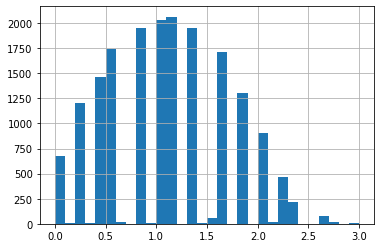

In [20]:
train_df.meanGrade.hist(bins=30)

In [21]:
def remove_outliers(df, ub):
    _df = df.copy()
    return _df[(_df.meanGrade <= ub)]

<AxesSubplot:>

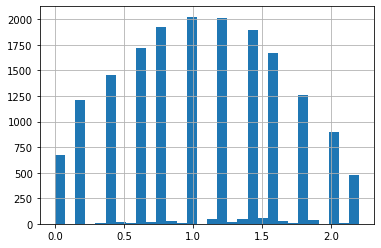

In [22]:
remove_outliers(train_df, ub=2.2).meanGrade.hist(bins=30)

### Preprocessing

In [23]:
nlp = spacy.load('en_core_web_lg')

In [24]:
print('GENSIM LIST OF WORD EMBEDDINGS')
api.info()['models'].keys()

GENSIM LIST OF WORD EMBEDDINGS


dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

**Note:** Ensure embeddings are being loaded from an appropriate local directory

In [491]:
embeddings = KeyedVectors.load_word2vec_format(
    './data/fasttext-wiki-news-subwords-300/fasttext-wiki-news-subwords-300.gz'
)

# embeddings = KeyedVectors.load_word2vec_format(
#     './data/word2vec_google_news_300/word2vec-google-news-300.gz',
#     binary=True
# )

# embeddings = KeyedVectors.load_word2vec_format(
#     './data/glove-twitter-100/glove-twitter-100.gz',
# )

# Need to convert all word to small case
# embeddings = KeyedVectors.load_word2vec_format(
#     './data/glove-wiki-gigaword-300/glove-wiki-gigaword-300.gz'
# )

#### Ekphrasis Preprocessor

In [492]:
text_processor = TextPreProcessor(
    annotate=['hashtag'],
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="english", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="english", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct=True,  # spell correction for elongated words
)

Reading english - 1grams ...
Reading english - 2grams ...
Reading english - 1grams ...


#### Some Test Case

In [493]:
fancy_ascii_apostrophe = 0
apostrophe_s = 12
apostrophe_s_2 = 43
contraction_won_t = 48
contraction_won_t_2 = 264
punct_check = 50
contraction_isnt_2 = 66
hashtag = 425 
hashtag2 = 529 
punct_exclaim = 80
punct_question = 27
punct_dash = 26
contraction_dont = 128
contraction_hell = 131
punct_twitter_handle = 4388

test_sentences = [
    fancy_ascii_apostrophe,
    apostrophe_s,
    apostrophe_s_2,
    contraction_won_t,
    contraction_won_t_2,
    punct_check,
    contraction_isnt_2,
    hashtag,
    hashtag2, 
    punct_exclaim,
    punct_question,
    punct_dash,
    contraction_dont,
    contraction_hell,
    punct_twitter_handle,
]

In [494]:
train_df.loc[test_sentences]

id                                           original           edit  \
0     14530  France is ‘ hunting down its citizens who join...          twins   
12     7614  Trump 's 2nd Nominee for <Army/> Secretary Wit...          Class   
43     5732  Fox 's James Murdoch rebukes <Trump/> over Cha...          grits   
48     3274  Kelly wo n't commit to defending DACA in <cour...          space   
264   13786  Franken Reiterates He Wo n't <Resign/> : ' I K...           diet   
50    13443  Rand Paul : Saudi Arabia ’s Role in Backing <T...     Turpentine   
66     7780  This Is n't ' Another Watergate ' But It Plays...     Vaudeville   
425   13225  Steve Bannon <Meets/> with Billionaire Mercer ...      canoodles   
529    3636            China Is Attempting To <Muzzle/> #MeToo          start   
80     8947  Trump to Dems : Of course I colluded , big <de...           time   
27    11124  If America is Great Again , Why Is the <Dollar...   intelligence   
26    12583  Oregon : 20-Year-Old Sues Kroger for <Refusing...         trying   
128    2104  Cold weather : Do n't <leave/> these things in...           Cook   
131    6095  ' I think he 'll be just fine ' : Trump hints ...  incarceration   
4388  12579  Who Is The Mystery <Man/> Behind @realDonaldTr...         turnip   

      grades  meanGrade  
0      10000        0.2  
12     22100        1.0  
43     10000        0.2  
48     33100        1.4  
264    31111        1.4  
50     10000        0.2  
66     11000        0.4  
425    21000        0.6  
529        0        0.0  
80     21000        0.6  
27     22210        1.4  
26     22100        1.0  
128    21100        0.8  
131    21000        0.6  
4388   32100        1.2

#### Correlation between position of replacement and humour

In [496]:
replacement_indices = train_df.original \
    .apply(lambda row: np.mean(re.search("<.*/>", row).span()))

corr_replacement_humour = pd.concat(
    [replacement_indices, train_df.meanGrade],
    axis=1
)

corr_replacement_humour.corr()

original  meanGrade
original   1.000000   0.101668
meanGrade  0.101668   1.000000

<AxesSubplot:xlabel='original', ylabel='meanGrade'>

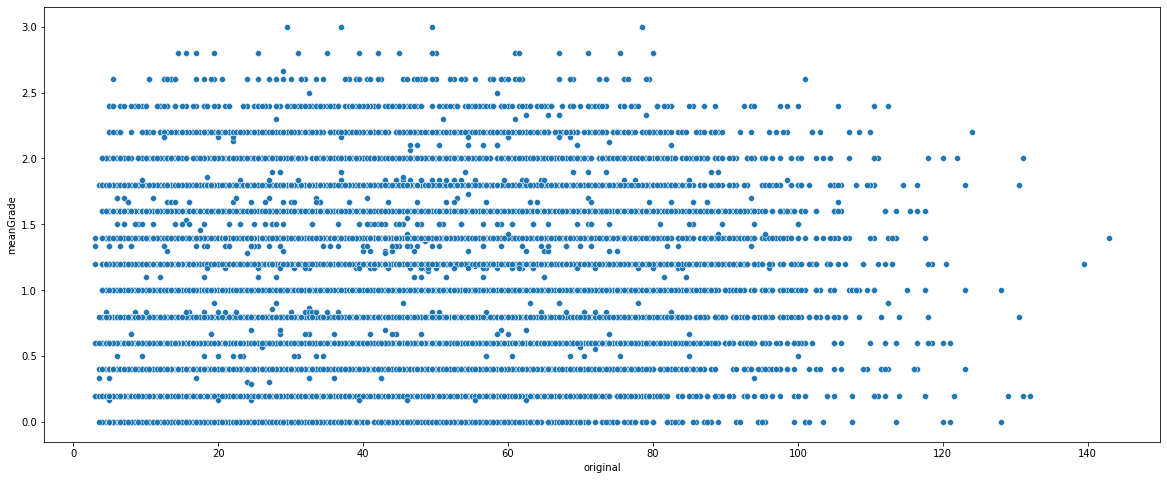

In [497]:
sns.scatterplot(x='original', y='meanGrade', data=corr_replacement_humour)

#### Merging replacements in the original dataset

In [498]:
edited_sentences = train_df[['original', 'edit']] \
    .apply(lambda x: re.subn("<.*/>", x[1], x[0])[0], axis=1)
edited_sentences.head()

0    France is ‘ hunting down its citizens who join...
1    Pentagon claims 2,000 % increase in Russian tr...
2    Iceland PM Calls Snap Vote as Pedophile Furor ...
3    In an apparent first , Iran and Israel slap ea...
4    Trump was told weeks ago that Flynn misled sch...
dtype: object

#### Removing apostrophes

In [499]:
edited_sentences.str.replace(" (?P<one>\w*'\w+)", lambda x: x.group("one"))[[0, 12, 43, 48, 50, 264, 66]]

<ipython-input-499-649f357cc77e>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  edited_sentences.str.replace(" (?P<one>\w*'\w+)", lambda x: x.group("one"))[[0, 12, 43, 48, 50, 264, 66]]


0      France is ‘ hunting down its citizens who join...
12     Trump's 2nd Nominee for Class Secretary Withdraws
43     Fox's James Murdoch rebukes grits over Charlot...
48        Kelly won't commit to defending DACA in space 
50     Rand Paul : Saudi Arabia ’s Role in Backing Tu...
264    Franken Reiterates He Won't diet : ' I Know Th...
66     This Isn't ' Another Watergate ' But It Plays ...
dtype: object

#### Named Entity Recognition (NER)

Pretrained Word2Vec doesn't represent "france" and "France" in the same way (case sensitive). There are many named entities for which this happens which could be problematic if we want to utilities context sensitive representations.

In [500]:
from spacy import displacy 

def ner_viewer(sentence):
    trial_doc = nlp(sentence)

    for ent in trial_doc.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)

    displacy.render(trial_doc, style="ent", jupyter=True)

In [501]:
ner_viewer(edited_sentences[0])
ner_viewer(edited_sentences[1120])
ner_viewer(edited_sentences[1477])

France 0 6 GPE
Iraq 74 78 GPE


Donald Trump 0 12 PERSON
Twitter 51 58 PRODUCT


Nobel Prize 31 42 WORK_OF_ART


In [502]:
# Analysing similiarty of vectors under google news embeddings
# top 10 similiarities

def similiarities(model, word1, word2, top_n=1000):
    top_words_list = model.similar_by_word(word1, topn=top_n)
    top_words_list2 = model.similar_by_word(word2, topn=top_n)
    top_words_set = set(w for w, sim in top_words_list)
    top_words_set2 = set(w for w, sim in top_words_list2)
    return top_words_list, top_words_list2, top_words_set.intersection(top_words_set2)

In [503]:
simlist1, simlist2, intersection = similiarities(embeddings, 'France', 'france')
intersection

{'-France',
 'AirFrance',
 'Belgium',
 'Belguim',
 'Boulogne',
 'Boulogne-Billancourt',
 'Bretagne',
 'Britain',
 'Britan',
 'Britanny',
 'Brittany',
 'Chateauroux',
 'Europe',
 'France-',
 'France.',
 'Franch',
 'Frence',
 'French',
 'Ile-de-France',
 'Italy',
 'Marseille',
 'Nimes',
 'Paris',
 'Poitou-Charentes',
 'Provence',
 'Spain',
 'Tarbes',
 'Versaille'}

Trump has a different meaning to trump, where the first ones refers to the ex-President and the second is the verb. For this reason, in the context of headlines, we are safer capitalising all words that are named entities, when we are using news-specific pretrained embeddings.

In [504]:
simlist1, simlist2, intersection = similiarities(embeddings, 'Trump', 'trump')
print(simlist1[:10])
print()
print(simlist2[:10])

[('Trumps', 0.7959632873535156), ('Trumpian', 0.7332221269607544), ('Trumping', 0.7272778749465942), ('Trumpism', 0.7086310982704163), ('Drumpf', 0.7022296190261841), ('Trump-like', 0.6928916573524475), ('Anti-Trump', 0.6859002709388733), ('Trump-branded', 0.6830976009368896), ('Trumped', 0.6769288778305054), ('Trump-related', 0.6740255355834961)]

[('trumps', 0.8457010388374329), ('trumping', 0.7876768112182617), ('non-trump', 0.7490019798278809), ('trumped', 0.7124733328819275), ('notrump', 0.6544545888900757), ('supercede', 0.6326020956039429), ('overrule', 0.6288058757781982), ('no-trump', 0.6278952360153198), ('override', 0.6258442401885986), ('supersede', 0.6115215420722961)]


In [505]:
# def tokenize(
#     data, 
#     is_lower=True, 
#     remove_stopwords=True, 
#     remove_puncts=True, 
#     remove_num=True, 
#     remove_currency=True
# ):
#     # Params for 
#     clean_text_param = {
#         "lower":False,                     # lowercase text
#         "no_line_breaks":True,           # fully strip line breaks as opposed to only normalizing them
#         "no_urls":False,                  # replace all URLs with a special token
#         "no_emails":False,                # replace all email addresses with a special token
#         "no_phone_numbers":False,         # replace all phone numbers with a special token
#         "no_numbers":False,               # replace all numbers with a special token
#         "no_digits":False,                # replace all digits with a special token
#         "no_currency_symbols":True,      # replace all currency symbols with a special token
#         "no_punct":True,                 # remove punctuations
#         "replace_with_punct":"",          # instead of removing punctuations you may replace them
#         "replace_with_number":"",
#         "replace_with_digit":"",
#         "replace_with_currency_symbol":"",
#         "lang":"en"                       # set to 'de' for German special handling
#     }

#     text_processor = TextPreProcessor(
#         annotate=['hashtag'],
#         fix_html=True,  # fix HTML tokens
        
#         # corpus from which the word statistics are going to be used 
#         # for word segmentation 
#         segmenter="english", 
        
#         # corpus from which the word statistics are going to be used 
#         # for spell correction
#         corrector="english", 
        
#         unpack_hashtags=True,  # perform word segmentation on hashtags
#         unpack_contractions=True,  # Unpack contractions (can't -> can not)
#         spell_correct=True,
#     )

#     tokenized_corpus = []

#     for sentence in data:

#         tokenized_sentence = []
#         # processed_sentence = text_processor.pre_process_doc(sentence)
#         # clean_sentence = clean(processed_sentence, **clean_text_param)
#         spacy_doc = nlp(sentence)

#         for token in spacy_doc:
#             processed_token = token
#             if (remove_stopwords and processed_token.is_stop):
#                 continue
#             elif (remove_puncts and processed_token.is_punct):
#               continue
#             elif (remove_num and processed_token.is_digit):
#               continue
#             elif (remove_currency and processed_token.is_currency):
#               continue
#             elif (is_lower):
#               tokenized_sentence.append(token.lower_)
#             else:
#               tokenized_sentence.append(token.text)

#         tokenized_corpus.append(tokenized_sentence)

#     return tokenized_corpus

In [506]:
def capitalisation_by_ner(sentence, lower, entities=['GPE', 'ORG', 'NORP', 'PERSON']):
    edited_row = []

    trial_doc = nlp(sentence)
        
    for tok in trial_doc:
        if tok.ent_type_ in entities and not lower:
            edited_row.append(tok.text)
        else:
            edited_row.append(tok.text.lower())
    
    return ' '.join(edited_row)

In [507]:
# Word replacement
# Join the contractions
# Tokenize
# remove stop words
# remove punct EXCEPT ! ? #
# Twitter handles

def preprocessor(df, lower=False):
    _df = pd.DataFrame(index=df.index, columns=['edited_sentences', 'meanGrade'])

    _df['meanGrade'] = df.meanGrade

    text_processor = TextPreProcessor(
        fix_html=True,  # fix HTML tokens

        # corpus from which the word statistics are going to be used 
        # for word segmentation 
        segmenter="english", 

        # corpus from which the word statistics are going to be used 
        # for spell correction
        corrector="english", 

        unpack_hashtags=False,  # perform word segmentation on hashtags
        unpack_contractions=False,  # Unpack contractions (can't -> can not)
        spell_correct=True,  # spell correction for elongated words
    )
    
    punct = "[\.,:;\(\)\[\]@\-\$£]"
    
    nltk.download('stopwords')
    stops = stopwords.words('english')

    # Word replacement + join the contractions
    # NOTE: need to deal with ' '
    # NOTE: Numbers/digits have not been removed
    # NOTE: We have removed all stop words. We analysed the sentiment of the stop 
    # words in the training set to determine if removing them would negatively 
    # affect our results. The motivation for this check was that any word with a 
    # sentiment would affect the funniness score of the sentence. 
    # Since stop words have no sentiment, they have been removed
    # This doesn't retain any twitter handles, but retains the hashtags

    _df['edited_sentences'] = df[['original', 'edit']] \
        .apply(lambda x: re.subn("<.*/>", x[1], x[0])[0], axis=1) \
        .apply(lambda x: capitalisation_by_ner(x, lower=lower)) \
        .str.replace(" (?P<one>\w*'\w+)", lambda x: x.group("one")) \
        .apply(lambda x: text_processor.pre_process_doc(x)) \
        .str.replace("#", "# ") \
        .str.replace("[‘’]", "'") \
        .str.replace("'s", "") \
        .str.replace(punct, "") \
        .apply(lambda x: " ".join([w for w in x.split(" ") if w not in stops])) \
        .str.replace("[0-9]", "")

    return _df

In [508]:
# Note: all words need to be lower for glove embeddings
sents = preprocessor(train_df, lower=False)
sents.loc[test_sentences]

Reading english - 1grams ...


[nltk_data] Downloading package stopwords to
[nltk_data]     /homes/rrr2417/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-507-a5d0527d5806>:44: FutureWarning: The default value of regex will change from True to False in a future version.
  _df['edited_sentences'] = df[['original', 'edit']] \


edited_sentences  meanGrade
0     France ' hunting citizens joined twins ' witho...        0.2
12           Trump nd nominee class secretary withdraws        1.0
43      Fox James Murdoch rebukes grits Charlottesville        0.2
48                    Kelly commit defending DACA space        1.4
264   Franken reiterates diet  ' know ' let lot peop...        1.4
50    Rand Paul  Saudi Arabia  role backing turpenti...        0.2
66      ' another watergate ' plays one tv – vaudeville        0.4
425   Steve Bannon canoodles billionaire Mercer Fami...        0.6
529                     China attempting start #  metoo        0.0
80    trump Dems  course colluded  big time ! fuck d...        0.6
27         America great  intelligence slowly sinking ?        1.4
26    Oregon    year  old sues Kroger trying sell sh...        1.0
128            cold weather  Cook things car temps fall        0.8
131   ' think he'll fine '  trump hints incarceratio...        0.6
4388  mystery turnip behind realdonaldtrump ?  besid...        1.2

#### Relationship between sentences length and mean grade

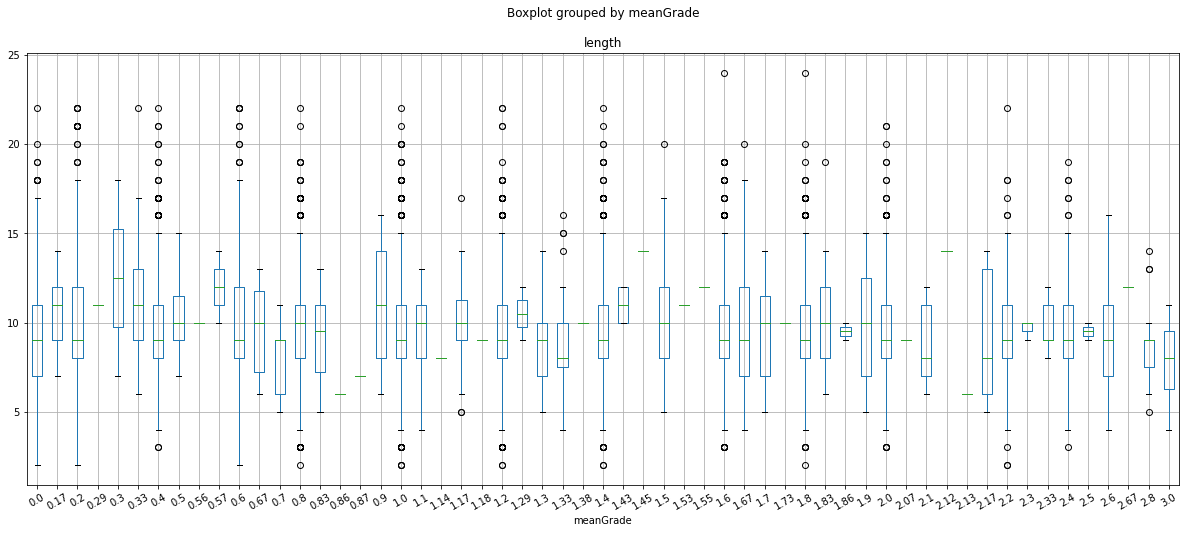

In [509]:
sentence_length = sents.edited_sentences.apply(lambda x: len(x.split(' ')))

plt.rcParams['figure.figsize'] = (20, 8)

plotter_df = pd.DataFrame(columns=['length', 'meanGrade'])
plotter_df.length = sentence_length
plotter_df.meanGrade = np.round(sents.meanGrade, 2)

boxplot = plotter_df.boxplot('length', 'meanGrade')
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=30)

plt.show()

### Checking cleaned corpus in embeddings

FastText embeddings from Gensim do not have common contractions such as "won't" and "don't" whereas Word2Vec do.

In [510]:
tokenized_words = sents.edited_sentences.map(lambda x: x.split(" "))
oov_words = []

for sentence in tokenized_words:
    for word in sentence:
        if word not in embeddings.vocab:
            oov_words.append(word)

In [511]:
from collections import Counter

oov_words_counter = Counter(oov_words)
print(oov_words_counter)

Counter({'': 16040, "n't": 300, "can't": 66, 'AT&T': 26, 'Sondland': 26, "he'll": 22, "they're": 21, 'Vindman': 16, 'Trumpcare': 15, 'soleimani': 15, 'metoo': 14, "we're": 13, "he'd": 12, 'TikTok': 12, 'mandalorian': 12, 'rosenstein': 11, 'ivanka': 11, 'manafort': 10, 'mulvaney': 10, "we'll": 9, 'danceoff': 9, 'amash': 9, 'grenfell': 8, 'parnas': 8, 'comey': 7, 'charlottesville': 7, 'usled': 7, 'AT&ampT': 7, 'manbun': 7, "DineshD'Souza": 6, 'Kushners': 6, 'glencore': 6, 'kaspersky': 6, 'nkorea': 6, "i'd": 6, 'Strzok': 6, 'cnnpoliticscom': 6, 'westworld': 6, 'trumpism': 6, 'rwc': 6, 'fortnite': 6, 'yovanovitch': 6, 'nunes': 6, 'Cybertruck': 6, 'apnewsbreak': 5, 'irma': 5, 'tillerson': 5, 'covfefe': 5, '`': 5, "BillO'Reilly": 5, 'degeneres': 5, 'coachella': 5, 'picchu': 5, "MartinO'Malley": 4, 'jinping': 4, 'sh*t': 4, 'gorsuch': 4, 'bigly': 4, "BetoO'Rourke": 4, 'tweetstorm': 4, 'Danceoff': 4, 'scorsese': 4, 'rogaine': 4, 'manbuns': 4, 'Zelenskiy': 4, 'USMCA': 4, 'dolittle': 4, 'Manassia

In [512]:
all_words = []
for sent in tokenized_words:
    all_words.extend(sent)

print(f'Failure Rate: {len(set(oov_words)) / len(set(all_words))}')

Failure Rate: 0.03242638837122624


### Analysing Stopwords in Corpus

In [513]:
print("don't" in stopwords.words('english'))

True


In [514]:
edited_sentences = train_df[['original', 'edit']] \
        .apply(lambda x: re.subn("<.*/>", x[1], x[0])[0], axis=1)
stops = set(stopwords.words('english'))
corpus_words = set(" ".join(list(edited_sentences)).split(" "))
inters = corpus_words.intersection(stops)

len(inters)

121

We checked if stopwords have any sentiment in common libraries. Below is one of the experiments we did.

In [515]:
nltk.download('opinion_lexicon')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /homes/rrr2417/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

In [516]:
from nltk.corpus import opinion_lexicon

pos_list = set(opinion_lexicon.positive())
neg_list = set(opinion_lexicon.negative())

## Model

In [517]:
# Proportion of training data for train compared to dev
train_proportion = 0.8

In [518]:
clean_train_df = preprocessor(train_df, lower=False)
clean_test_df = preprocessor(test_df, lower=False)

Reading english - 1grams ...


[nltk_data] Downloading package stopwords to
[nltk_data]     /homes/rrr2417/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-507-a5d0527d5806>:44: FutureWarning: The default value of regex will change from True to False in a future version.
  _df['edited_sentences'] = df[['original', 'edit']] \


Reading english - 1grams ...


[nltk_data] Downloading package stopwords to
[nltk_data]     /homes/rrr2417/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [519]:
## Approach 1 code, using functions defined above:

# We set our training data and test data
training_data = clean_train_df['edited_sentences']
test_data = clean_test_df['edited_sentences']

# Creating word vectors
training_vocab, training_tokenized_corpus = create_vocab(training_data)
test_vocab, test_tokenized_corpus = create_vocab(test_data)

# Creating joint vocab from test and train:
joint_vocab, joint_tokenized_corpus = create_vocab(pd.concat([training_data, test_data]))

print("Vocab created.")

Vocab created.


In [520]:
# We create representations for our tokens
wvecs = [] # word vectors
word2idx = [] # word2index
idx2word = []

index = 1

for word in joint_vocab:
    if word in embeddings.vocab:
        vec = embeddings.get_vector(word)
        wvecs.append(vec)
        word2idx.append((word, index))
        idx2word.append((index, word))
        index += 1

vector_dim = len(wvecs[0])
wvecs.insert(0, np.zeros(vector_dim))
wvecs = np.array(wvecs)
word2idx = dict(word2idx)
idx2word = dict(idx2word)

vectorized_seqs = [
    [word2idx[tok] for tok in seq if tok in word2idx]
    for seq in training_tokenized_corpus
]

# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs = [x if len(x) > 0 else [0] for x in vectorized_seqs]

In [521]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """
    print("Training model.")

    for epoch in range(1, number_epoch+1):

        model.train()
        epoch_loss = 0
        epoch_sse = 0
        no_observations = 0  # Observations used for training so far

        for batch in train_iter:

            feature, target = batch

            feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden = model.init_hidden()

            # print(feature)

            predictions = model(feature)
            # print(predictions.shape)
            predictions = predictions.squeeze(1)
            
            # print(predictions.mean(), predictions.std())

            optimizer.zero_grad()

            loss = loss_fn(predictions, target)

            sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * target.shape[0]
            epoch_sse += sse

        valid_loss, valid_mse, __, __ = eval(dev_iter, model)

        epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')

In [535]:
# We evaluate performance on our dev set
def eval(data_iter, model):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    pred_all = []
    trg_all = []
    no_observations = 0

    with torch.no_grad():
        for batch in data_iter:
            feature, target = batch

            feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden = model.init_hidden()

            predictions = model(feature).squeeze(1)
            loss = loss_fn(predictions, target)

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            sse, __ = model_performance(pred, trg)

            epoch_loss += loss.item() * target.shape[0]
            epoch_sse += sse
            pred_all.extend(pred)
            trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [523]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse

In [524]:
def create_vocab(data):
    """
    Creating a corpus of all the tokens used
    """
    tokenized_corpus = [] # Let us put the tokenized corpus in a list
    
    for sentence in data:
        tokenized_sentence = []
        for token in sentence.split(' '): # simplest split is
            tokenized_sentence.append(token)
        tokenized_corpus.append(tokenized_sentence)

    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

    for sentence in tokenized_corpus:
        for token in sentence:
            if token not in vocabulary:
                if True:
                    vocabulary.append(token)

    return vocabulary, tokenized_corpus

In [525]:
def collate_fn_padd(batch):
    '''
    We add padding to our minibatches and create tensors for our model
    '''
    batch_labels = [l for f, l in batch]
    batch_features = [f for f, l in batch]

    batch_features_len = [len(f) for f, l in batch]

    seq_tensor = torch.zeros((len(batch), max(batch_features_len))).long()

    for idx, (seq, seqlen) in enumerate(zip(batch_features, batch_features_len)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

    batch_labels = torch.FloatTensor(batch_labels)

    return seq_tensor, batch_labels

class Task1Dataset(Dataset):

    def __init__(self, train_data, labels):
        self.x_train = train_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]

In [526]:
import torch.nn.functional as F

class LearnedAffineTransform(nn.Module):
    
    def __init__(self, loc=None, scale=None):

        super(LearnedAffineTransform, self).__init__()
        # loc=loc, scale=scale, **kwargs)

        if loc is None:
            self.loc = torch.nn.Parameter(torch.zeros([1, ]))
        if scale is None:
            self.scale = torch.nn.Parameter(torch.ones([1, ]))

    def _broadcast(self, val):
        dim_extension = tuple(1 for _ in range(val.dim() - 1))
        loc = self.loc.view(-1, *dim_extension)
        scale = self.scale.view(-1, *dim_extension)

        return loc, scale

    def forward(self, x):
        loc, scale = self._broadcast(x)
        return loc + scale * x


class BiLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size,
                 device, stacks=1, lstm_dropout=0, bi=False):
        super(BiLSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size
        self.stacks = stacks
        self.bi = bi
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=bi,
                            num_layers=stacks, dropout=lstm_dropout)

        # The linear layer that maps from hidden state space to tag space
        if bi:
            self.hidden_dim *= 2
            
        output_dims = 64
            
        self.fc = nn.Sequential(
            nn.Linear(self.hidden_dim, output_dims),
            nn.Dropout(0.3),
            nn.LeakyReLU(),
            # nn.Linear(output_dims, output_dims),
            # nn.Dropout(0.5),
            # nn.LeakyReLU(),
            nn.Linear(output_dims, 1),
        )
            
        self.hidden = self.init_hidden()
        
        # self.affine = LearnedAffineTransform()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        start_dim = self.stacks
        if self.bi:
            start_dim *= 2
        
        return torch.zeros(start_dim, self.batch_size, self.hidden_dim).to(self.device), \
               torch.zeros(start_dim, self.batch_size, self.hidden_dim).to(self.device)

    def forward(self, sentence):
        embedded = self.embedding(sentence)
        embedded = embedded.permute(1, 0, 2)

        lstm_out, self.hidden = self.lstm(
            embedded.view(embedded.shape[0], self.batch_size, self.embedding_dim),
            self.hidden
        )

        out = self.fc(lstm_out[-1])
        return out
        # out = self.affine(F.exp(out))
        # out = torch.distributions.transforms.ExpTransform()(out)
        # return out

In [559]:
INPUT_DIM = len(word2idx)
EMBEDDING_DIM = wvecs.shape[1]
BATCH_SIZE = 52
HIDDEN_DIM = 10

model = BiLSTM(EMBEDDING_DIM, HIDDEN_DIM, INPUT_DIM + 1,
               BATCH_SIZE, device, stacks=2, lstm_dropout=0.5)
print("Model initialised.")

model.to(device)
# We provide the model with our embeddings
model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

feature = vectorized_seqs

# 'feature' is a list of lists, each containing embedding IDs for word tokens
train_and_dev = Task1Dataset(feature, train_df['meanGrade'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples

train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

# Better suited to heavy tail distributions
loss_fn = nn.SmoothL1Loss(beta=0.5)
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

epochs = 50

Model initialised.
Dataloaders created.


In [560]:
"""
BiLSTM(
  (embedding): Embedding(19128, 300, padding_idx=0)
  (lstm): LSTM(300, 10, num_layers=2, dropout=0.5)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
epochs = 45
lre-5
| Epoch: 45 | Train Loss: 0.27 | Train MSE: 0.34 | Train RMSE: 0.58 |
| Val. Loss: 0.28 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
./data/fasttext-wiki-news-subwords-300/fasttext-wiki-news-subwords-300.gz

Centered around the mean - cannot learn the lower or higher tails
Due to the embeddings not having many useful words in them.
| Epoch: 45 | Train Loss: 0.29 | Train MSE: 0.35 | Train RMSE: 0.59 |
| Val. Loss: 0.28 | Val. MSE: 0.34 |  Val. RMSE: 0.59 |

Same issue as previous
| Epoch: 45 | Train Loss: 0.30 | Train MSE: 0.37 | Train RMSE: 0.61 |
| Val. Loss: 0.29 | Val. MSE: 0.35 |  Val. RMSE: 0.60 |
"""

model

BiLSTM(
  (embedding): Embedding(19128, 300, padding_idx=0)
  (lstm): LSTM(300, 10, num_layers=2, dropout=0.5)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [561]:
train(train_loader, dev_loader, model, epochs)

Training model.
| Epoch: 01 | Train Loss: 0.76 | Train MSE: 1.31 | Train RMSE: 1.15 |         Val. Loss: 0.75 | Val. MSE: 1.29 |  Val. RMSE: 1.13 |
| Epoch: 02 | Train Loss: 0.73 | Train MSE: 1.25 | Train RMSE: 1.12 |         Val. Loss: 0.72 | Val. MSE: 1.22 |  Val. RMSE: 1.10 |
| Epoch: 03 | Train Loss: 0.70 | Train MSE: 1.18 | Train RMSE: 1.09 |         Val. Loss: 0.69 | Val. MSE: 1.15 |  Val. RMSE: 1.07 |
| Epoch: 04 | Train Loss: 0.67 | Train MSE: 1.11 | Train RMSE: 1.05 |         Val. Loss: 0.65 | Val. MSE: 1.08 |  Val. RMSE: 1.04 |
| Epoch: 05 | Train Loss: 0.63 | Train MSE: 1.04 | Train RMSE: 1.02 |         Val. Loss: 0.62 | Val. MSE: 1.01 |  Val. RMSE: 1.00 |
| Epoch: 06 | Train Loss: 0.60 | Train MSE: 0.96 | Train RMSE: 0.98 |         Val. Loss: 0.58 | Val. MSE: 0.92 |  Val. RMSE: 0.96 |
| Epoch: 07 | Train Loss: 0.56 | Train MSE: 0.88 | Train RMSE: 0.94 |         Val. Loss: 0.54 | Val. MSE: 0.83 |  Val. RMSE: 0.91 |
| Epoch: 08 | Train Loss: 0.51 | Train MSE: 0.79 | Train RMS

## Validation Set Evaluation

In [562]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2419 entries, 0 to 2418
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           2419 non-null   int64  
 1   original     2419 non-null   object 
 2   edit         2419 non-null   object 
 3   grades       2419 non-null   int64  
 4   meanGrade    2419 non-null   float64
 5   predictions  2419 non-null   float32
 6   difference   2419 non-null   float32
 7   target       2419 non-null   float32
dtypes: float32(3), float64(1), int64(2), object(2)
memory usage: 123.0+ KB


In [563]:
vectorized_seqs_test = [
    [word2idx[tok] for tok in seq if tok in word2idx]
    for seq in test_tokenized_corpus
]
test
# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs_test = [x if len(x) > 0 else [0] for x in vectorized_seqs_test]

In [564]:
train_and_dev_loader = torch.utils.data.DataLoader(train_and_dev, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

test_dataset = Task1Dataset(vectorized_seqs_test, test_df['meanGrade'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

In [565]:
loss, mse, predictions, target = eval(test_loader, model)
model_performance(predictions, target, print_output=True)

loss_t, mse_t, predictions_t, target_t = eval(train_and_dev_loader, model)
model_performance(predictions_t, target_t, print_output=True)

| MSE: 0.36 | RMSE: 0.60 |
| MSE: 0.26 | RMSE: 0.51 |


(4698.9004, 0.2625084)

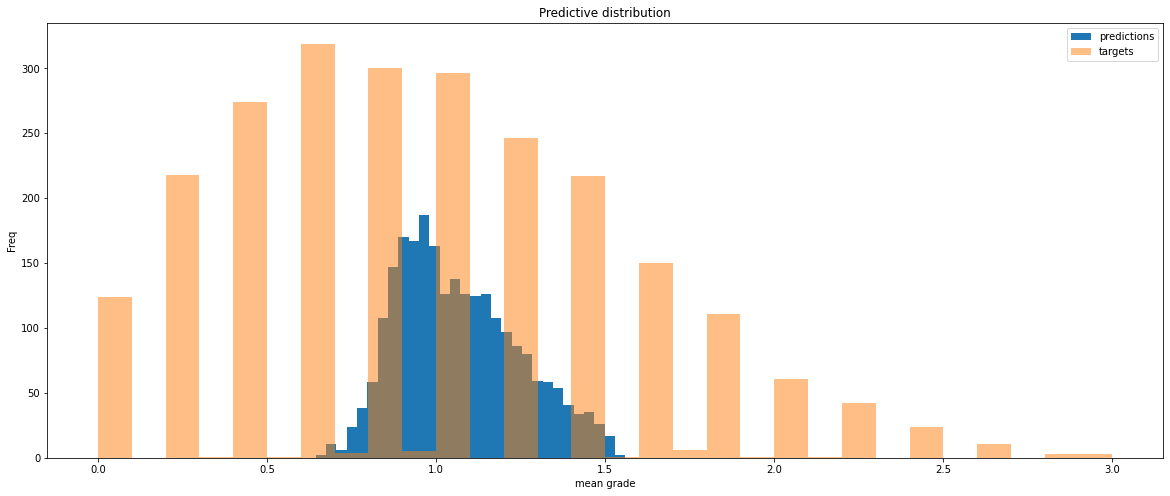

In [566]:
plt.title('Predictive distribution')
plt.xlabel('mean grade')
plt.ylabel('Freq')
plt.hist(predictions, bins=30, label='predictions')
plt.hist(target, bins=30, alpha=0.5, label='targets')
plt.legend()
plt.show()

In [567]:
print(min(predictions))
print(max(predictions))
rounded_preds = np.round_(predictions, decimals=2)
print(min(rounded_preds))
print(max(rounded_preds))

0.6443602
1.5589774
0.64
1.56


In [568]:
diff = abs(predictions - target)
test_df['predictions'] = predictions
test_df['difference'] = diff
test_df['target'] = target
results_df = test_df[diff > 0.5][['original', 'edit', 'meanGrade', 'predictions', 'target', 'difference']]

diff_t = abs(predictions_t - target_t)
train_eval_df = train_df.copy(deep=True)
train_eval_df['predictions'] = predictions_t
train_eval_df['difference'] = diff_t
train_eval_df['target'] = target_t

results_df.head(10)

original       edit  meanGrade  \
3   N.Y. Times <reprimands/> reporter for sharing ...   applauds        1.6   
4   Vladimir Putin Releases Video Simulation Of Ru...    balloon        0.4   
5   Ex-Goldman Sachs boss , Obama ambassador Murph...      chase        0.4   
9              Taliban <kill/> 95 with ambulance bomb      bores        0.4   
11  White House blasts <request/> from China as ' ...        ice        0.4   
19  Sen. Murphy on Dem 's Georgia <loss/> : Russia...    peaches        1.4   
24              <Russia/> still developping new nukes       Duke        0.2   
25  White House blasts request from China as ' Orw...      novel        0.0   
26  Kushner to visit <Mexico/> following latest Tr...  therapist        2.8   
28  Hillary Clinton ‘ Convinced ’ Trump Associates...     waffle        0.4   

    predictions  target  difference  
3      0.987609     1.6    0.612391  
4      1.373463     0.4    0.973463  
5      1.323330     0.4    0.923330  
9      0.901893     0.4    0.501893  
11     0.964602     0.4    0.564602  
19     0.875771     1.4    0.524229  
24     0.965926     0.2    0.765926  
25     1.025098     0.0    1.025098  
26     1.046975     2.8    1.753025  
28     0.995252     0.4    0.595252

In [578]:
test_df.to_csv('results_fasttext.csv')

In [570]:
for i in range(1):
    index = results_df.index[i]
    print(results_df['original'][index], " | ", results_df['edit'][index], " | ", results_df['meanGrade'][index], results_df['predictions'][index])

N.Y. Times <reprimands/> reporter for sharing ' unfounded rumor ' about Melania Trump  |  applauds  |  1.6 0.98760945


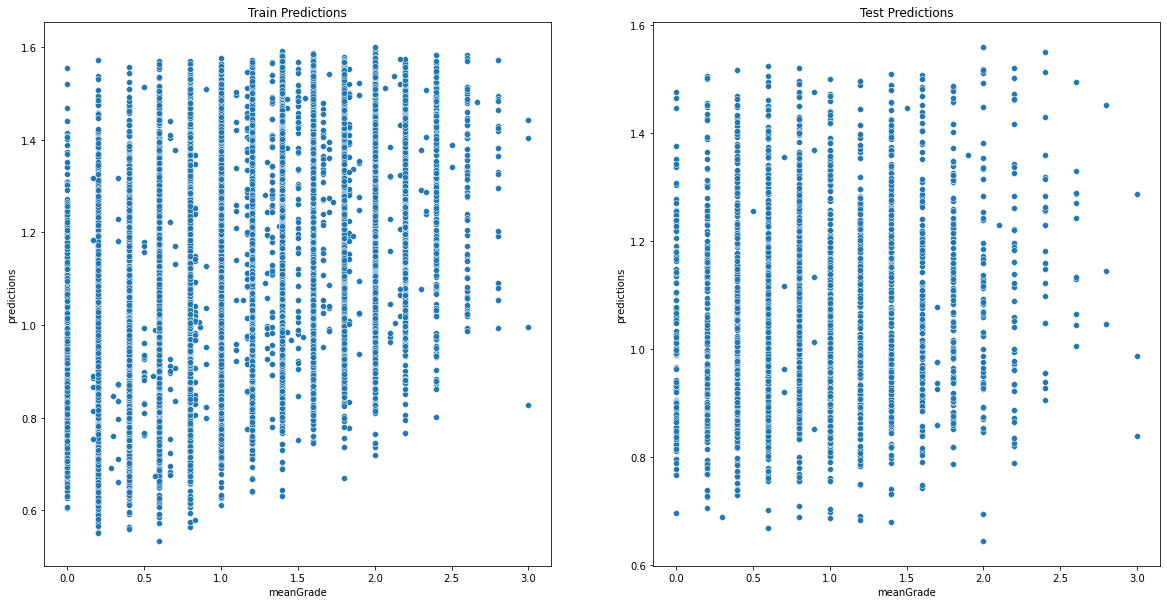

In [571]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))

sns.scatterplot(x='meanGrade', y='predictions', data=train_eval_df, ax=ax1)
sns.scatterplot(x='meanGrade', y='predictions', data=test_df, ax=ax2)
ax1.set_title('Train Predictions')
ax2.set_title('Test Predictions')

plt.show()

<Figure size 1440x1440 with 0 Axes>

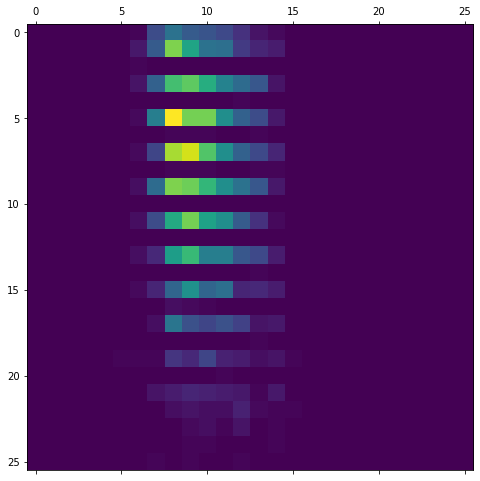

In [572]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(20, 20))
rounded_preds = np.round_(predictions, decimals=1)
conf = confusion_matrix(
    (target * 10).astype(int),
    (rounded_preds * 10).astype(int),
    normalize='all'
)
plt.matshow(conf)
plt.show()

The box plot shows us that even with significant tuning and attempts to make the network better suited to the heavy tails, we cannot force the network to better predict the tails.

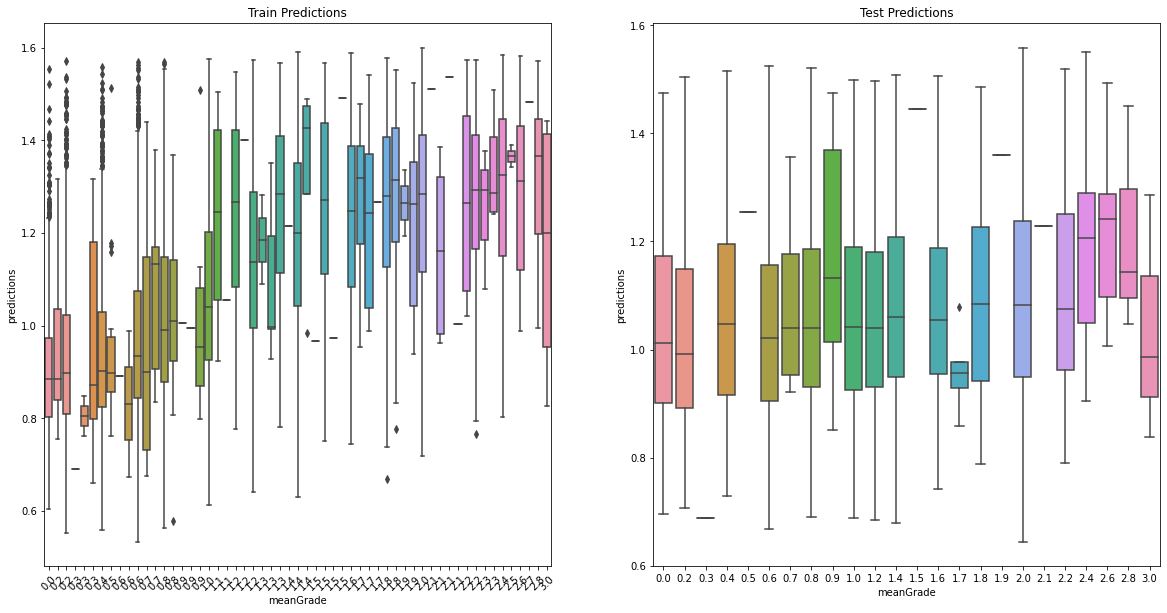

In [573]:
from matplotlib.text import Text

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))

sns.boxplot(x='meanGrade', y='predictions', data=train_eval_df, ax=ax1)
ax1.set_xticklabels([
    Text(*t.get_position(), str(np.round(float(t.get_text()), 1)))
    for t in ax1.get_xticklabels()
], rotation=45)
sns.boxplot(x='meanGrade', y='predictions', data=test_df, ax=ax2)
ax1.set_title('Train Predictions')
ax2.set_title('Test Predictions')

plt.show()

In [197]:
low_grade = train_eval_df[(train_eval_df['meanGrade'] < 0.3) & (train_eval_df['difference'] >= 1.0)]
low_grade.head(30)

id                                           original          edit  \
234   13027   <Donald Trump Jr./> should publicly testify i...      Accident   
316    2941   <Taiwan/> court to rule in in landmark same-s...  Heterosexual   
350    2673  Bernie Sanders and 16 <Senate/> Dems just rele...      Homeless   
618    1270  Trump reveled in leaks that <hurt/> Hillary Cl...     straggled   
655    6848  China offers support , help to <Myanmar/> afte...         plane   
699   15078  At Singapore regional <defense/> dialogue , it...         party   
842   12237  Trump physical unlikely to shed light on menta...         magic   
933   11941  US ambassador to Netherlands <describes/> own ...     discovers   
940    7204  Barclays former CEO John Varley and three top ...        murder   
1169   2548  Scientists turn <hydrogen/> into metal in brea...      aluminum   
1632   4232  Somewhere between his hero , Justice Scalia , ...          hero   
1682  11013       Useful Idiots Galore - The New <York/> Times        dinner   
2051  12492  Islamic television station in Senegal <blames/...         lauds   
2059   4060  BREAKING : Trump considering <options/> for Sy...    toothpaste   
2426   6481  Trump : I still ' would like to ' <sit/> down ...         dress   
2429   1617  All the Experts Who Told Us Stocks Would <Cras...       Plummet   
2729   2633  Democrats ' call to action after Vegas <shooti...     residency   
2944    468  Northern Ireland : Ryan McLaughlin <replaces/>...         joins   
3185   4392  ' The Trump slump ' : Remington files for bank...       bayonet   
3309  14210  Ex-Trump official Carl Higbie <defends/> racis...        paints   
3361    160  House Republicans start the new Congress with ...      officers   
3416  13379  Republicans formally <roll/> out tax plan -- l...         stamp   
3460   7362  Trump 's attorney being investigated for bank ...     President   
3479   9637  Trump ousts Secretary of State Tillerson , tap...        kitten   
3488  13553  24 <senators/> co-sponsor bipartisan ObamaCare...     partisans   
3817    852  School shooting in Mexico : Kid <opens/> fire ...        starts   
4003  14836        Why Christians Must Support <Gun Control/>       Abortion   
4359  14454  US missile defense test triggers alarm in Russ...         story   
4446   6423  Trump distances himself from Ed Gillespie afte...         chase   
4513   9354  Essential Politics : California 's hottest con...       battles   

      grades  meanGrade  predictions  difference  target  
234    10000        0.2     1.653015    1.453015     0.2  
316        0        0.0     1.855201    1.855201     0.0  
350    10000        0.2     1.218110    1.018110     0.2  
618        0        0.0     1.142003    1.142003     0.0  
655    10000        0.2     1.371435    1.171435     0.2  
699    10000        0.2     1.239954    1.039954     0.2  
842    10000        0.2     1.783349    1.583349     0.2  
933        0        0.0     1.292444    1.292444     0.0  
940        0        0.0     1.591395    1.591395     0.0  
1169       0        0.0     1.205685    1.205685     0.0  
1632       0        0.0     1.939715    1.939715     0.0  
1682   10000        0.2     1.249557    1.049557     0.2  
2051   10000        0.2     1.371131    1.171131     0.2  
2059   10000        0.2     1.345467    1.145467     0.2  
2426   10000        0.2     1.388388    1.188388     0.2  
2429       0        0.0     1.119968    1.119968     0.0  
2729   10000        0.2     1.491181    1.291181     0.2  
2944       0        0.0     1.310973    1.310973     0.0  
3185   10000        0.2     1.758573    1.558573     0.2  
3309       0        0.0     1.111538    1.111538     0.0  
3361       0        0.0     1.381514    1.381514     0.0  
3416       0        0.0     1.059142    1.059142     0.0  
3460   10000        0.2     1.376545    1.176545     0.2  
3479   10000        0.2     1.552403    1.352403     0.2  
3488   10000        0.2     1.208042    1.008042     

## Final Test Prediction

In [581]:
test_df = pd.read_csv(f'{data_dir}/test.csv')

test_df.head(10)

(3024, 5)


id                                           original         edit  \
0     36  The Latest : Election tally shows <Austria/> t...         Cars   
1   2157  House Intel <Republicans/> Have Cleared Trump ...       onions   
2   9385  Christmas Is Canceled : Nazareth ’s Muslim <Ma...        grump   
3  14434  White House says Trump 's legal <team/> suppor...        bozos   
4   9462  Election <analysts/> move Ryan seat toward Dem...       movers   
5   5773  In long-feared twist , online leak rattles Fre...      bulldog   
6  11975  Flynn has promised Special Counsel ' full coop...         anal   
7  10047  Jones does n't think Trump should resign over ...      singing   
8   9595  As a Black veteran , I always stand for the <f...  quarterback   
9  12085  A plan to tax US <imports/> has better odds of...         pets   

   grades  meanGrade  
0   31110        1.2  
1   11000        0.4  
2   11111        1.0  
3   32210        1.6  
4   11000        0.4  
5   11100        0.6  
6   32210        1.6  
7   21111        1.2  
8   21110        1.0  
9   11000        0.4

In [584]:
final_test_df = preprocessor(test_df, lower=False)

# Create vocab
final_test_vocab, final_test_tokenized_corpus = create_vocab(final_test_data)

vectorized_seqs_test_final = [
    [word2idx[tok] for tok in seq if tok in word2idx]
    for seq in final_test_tokenized_corpus
]

# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs_test_final = [x if len(x) > 0 else [0] for x in vectorized_seqs_test_final]

final_test_dataset = Task1Dataset(vectorized_seqs_test_final, final_test_df['meanGrade'])
final_test_loader = torch.utils.data.DataLoader(final_test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

Reading english - 1grams ...


[nltk_data] Downloading package stopwords to
[nltk_data]     /homes/rrr2417/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-507-a5d0527d5806>:44: FutureWarning: The default value of regex will change from True to False in a future version.
  _df['edited_sentences'] = df[['original', 'edit']] \


In [585]:
loss, mse, predictions, target = eval(final_test_loader, model)
model_performance(predictions, target, print_output=True)

| MSE: 0.34 | RMSE: 0.58 |


(1014.8707, 0.3356054)

In [587]:
final_test_df['predictions'] = predictions

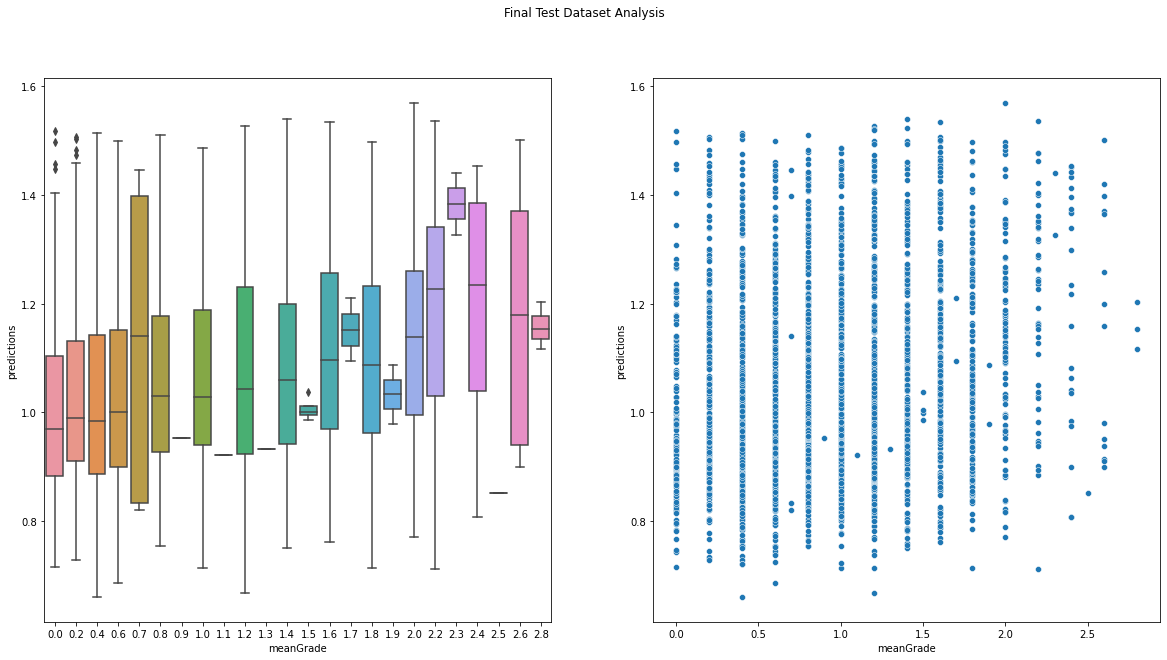

In [591]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))

fig.suptitle('Final Test Dataset Analysis')
sns.boxplot(x='meanGrade', y='predictions', data=final_test_df, ax=ax1)
sns.scatterplot(x='meanGrade', y='predictions', data=final_test_df, ax=ax2)
plt.show()